# It's a recommendation system for booked driver. The idea is to avoid these busy areas when they are on duties for delivering.

In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import time
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice
from keras.models import load_model

register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
# load data traffic

trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"') # from local data file

#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"') # from remote data file

trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
initial_day = 1
num_of_days = 14
range_btwn_pts = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_day) & (trf_df_sort.day < (initial_day + num_of_days))])

In [5]:
latlon = trf_week1.groupby('geohash6')['geohash6'].unique().apply(lambda x: geohash.decode(x[0]))
coords = np.array([idx for idx in latlon])

In [6]:
# build the cluster
start_time = time.time()
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
elapsed_time = time.time() - start_time
print('Time taken to cluster: {} secs'.format(elapsed_time))
#print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Time taken to cluster: 0.043375253677368164 secs


0     [[-5.48492431640625, 90.6536865234375], [-5.47...
1     [[-5.46295166015625, 90.6536865234375], [-5.45...
2     [[-5.48492431640625, 90.6646728515625], [-5.47...
3     [[-5.48492431640625, 90.6756591796875], [-5.47...
4     [[-5.48492431640625, 90.6866455078125], [-5.47...
5     [[-5.48492431640625, 90.6976318359375], [-5.47...
6     [[-5.41351318359375, 90.5877685546875], [-5.40...
7     [[-5.41351318359375, 90.5987548828125], [-5.40...
8     [[-5.41351318359375, 90.6097412109375], [-5.40...
9               [[-5.43548583984375, 90.6427001953125]]
10              [[-5.43548583984375, 90.6536865234375]]
11    [[-5.41351318359375, 90.6207275390625], [-5.40...
12    [[-5.41351318359375, 90.6317138671875], [-5.40...
13    [[-5.41351318359375, 90.6427001953125], [-5.40...
14    [[-5.41351318359375, 90.6536865234375], [-5.40...
15    [[-5.41900634765625, 90.6646728515625], [-5.41...
16    [[-5.30914306640625, 90.5987548828125], [-5.30...
17              [[-5.29266357421875, 90.62072753

In [10]:
# setup datetimestamp
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*num_of_days)]
trf_week1["dts_cal"] = [start_date + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_week1[["day", "timestamp"]].values]

# apply the cluster to dataframe
latlon_clusters = {tuple(g): idx for idx,c in enumerate(clusters) for g in clusters[idx]}
trf_week1.loc[:, 'latlon'] = trf_week1.geohash6.map(lambda x: geohash.decode(x))
trf_week1['lat'] = [ll[0][0] for ll in trf_week1[['latlon']].values]
trf_week1['lon'] = [ll[0][1] for ll in trf_week1[['latlon']].values]
trf_week1['cluster_ids'] = [latlon_clusters[t] for t in trf_week1['latlon']]

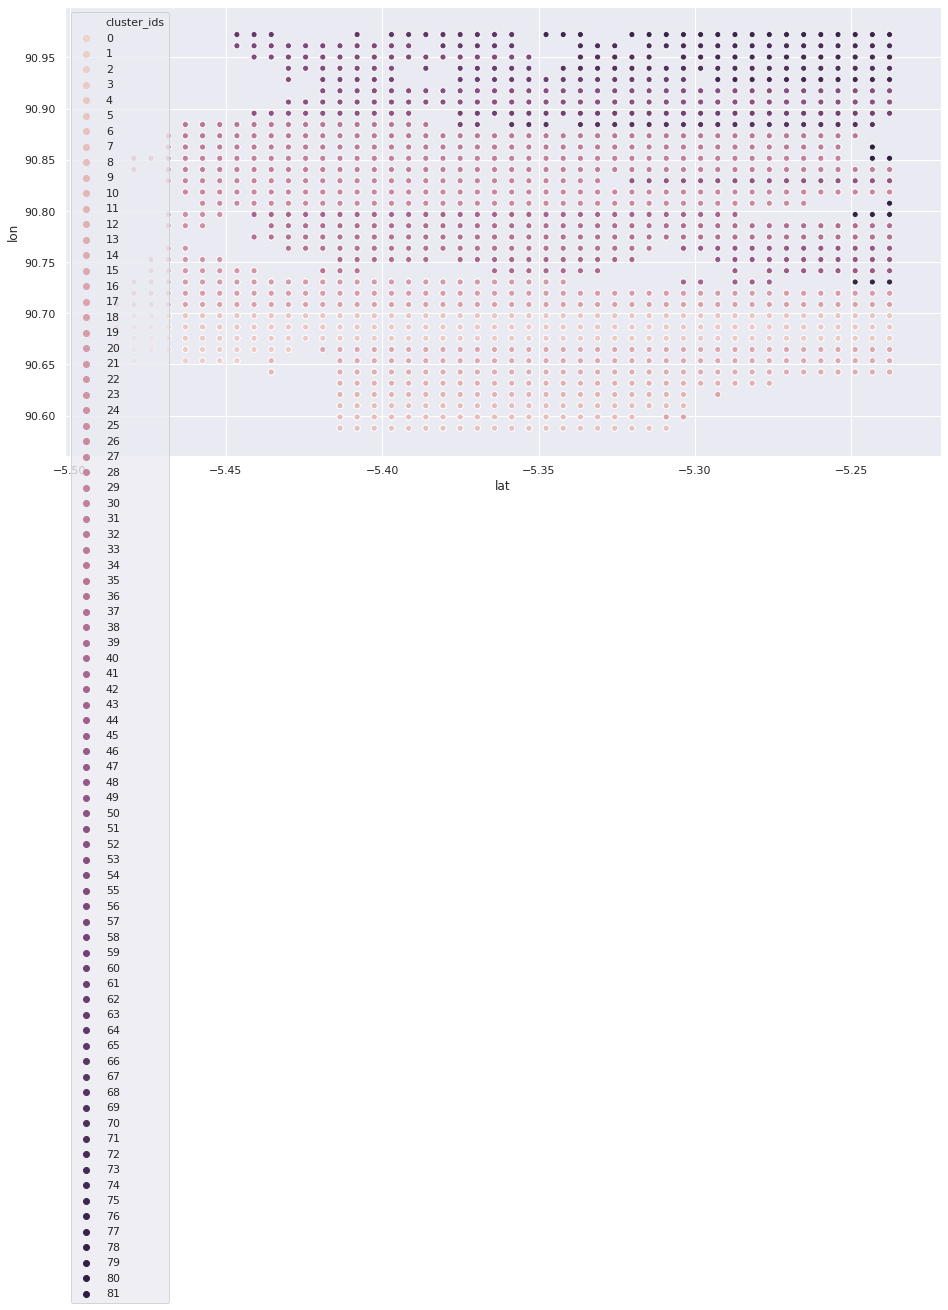

In [11]:
# visualize the cluster using scatterplot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.scatterplot(x='lat', y='lon', hue='cluster_ids', data=trf_week1, legend='full')

In [12]:
# using model created for weekly prediction

# visualize the high demand cluster
